In [1]:
import h5py
import numpy as np
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple

In [2]:
sns.reset_defaults()
sns.set_theme(context='paper',style='white',palette=sns.color_palette("bright"),font_scale=1.5,font='serif')


def image_extraction(filename: str) -> Tuple[np.ndarray, pd.DataFrame]:
    """Extract images as well as the foldless dataset. The indices will match between ds and image array, but not ID."""
    with h5py.File(filename, 'r') as dataset:
        ds = pd.DataFrame()
        images = []

        for i, fold in enumerate(dataset.keys()):
            # Accessing datasets directly
            patient_idx = np.array(dataset[fold]['patient_idx'])
            level = np.array(dataset[fold]['level'])
            diagnosis = np.array(dataset[fold]['diagnosis'])
            fold_images = np.array(dataset[fold]['image'])

            # Building the DataFrame
            df = pd.DataFrame({'ID': patient_idx, 'target': level, 'diagnosis': diagnosis, 'fold': i})
            ds = pd.concat([ds, df], ignore_index=True)

            # Append images
            images.append(fold_images)

        # Concatenating all images from all folds
        images = np.concatenate(images, axis=0)
        images = images.reshape(len(images), 800, 800)

        return images, ds

def decode_linear(predictions):
    new_predictions = np.array(predictions)
    new_predictions[predictions > 3.5] = 4
    new_predictions[predictions < 3.5] = 3
    new_predictions[predictions < 2.5] = 2
    new_predictions[predictions < 1.5] = 1
    new_predictions[predictions < 0.5] = 0

    return new_predictions

def test_result_extraction_regression(filename):
    """Make dataframe of prediction for regression tasks, and decode predictions."""
    with h5py.File(filename, 'r') as f:
        pred = np.array(f['predicted'][:]).flatten()  # Flattening in case it's not already
        patient = np.array(f['patient_idx'][:])
        y = np.array(f['y'][:])  # Assuming y is already the correct class or will be decoded similarly

    # Decode predictions to discrete classes
    pred_classes = decode_linear(pred)

    df = pd.DataFrame({'pred_class': pred_classes, 'label': y}, index=patient)
    df['error'] = df['pred_class'] - df['label']  # Calculating error if needed
    return df
  
def check_wrong(df, show_images=True, original_dataset=None, images=None):
    
   # Identifying where predictions do not match labels
    wrong = df.iloc[np.where(df['pred_class'] != df['label'])[0]].index
    
    # Creating a normalized confusion matrix
    cm = sklearn.metrics.confusion_matrix(df['label'], df['pred_class'], normalize='true')
    # Define the new labels for the display
    labels_display = ['Level 1', 'Level 2', 'Level 3']
    disp = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_display)
    disp.plot()
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    # Adjust the tick labels to show your new labels
    plt.xticks(ticks=[0, 1, 2], labels=labels_display)
    plt.yticks(ticks=[0, 1, 2], labels=labels_display, rotation=90)
    plt.show()

    # Marking predictions as correct or wrong
    df['result'] = 'Correct'
    df.loc[wrong, 'result'] = 'Wrong'
    df_wrong = df.loc[wrong]

    # Show images for wrong predictions if requested
    if show_images and original_dataset is not None and images is not None:
        for idx in wrong[:10]:
            image_idx = original_dataset[original_dataset['ID'] == idx].index[0]
            plt.figure()
            plt.imshow(images[image_idx], cmap='gray')
            plt.axis('off')
            # Ensure diagnosis and prediction information is correctly displayed
            plt.title(f'ID: {idx}, True Class: {df.loc[idx, "label"]}, Predicted Class: {df.loc[idx, "pred_class"]}')
            plt.show()

    return df_wrong

In [23]:
def plot_violin(df):
    """
    Plot violin plots showing predicted class vs predicted probability.
    Assumes 'pred_class' for predictions and 'probability' for predicted probabilities.
    """
    # Create a new figure for the violin plots
    plt.figure(figsize=(10, 6))

    # Create the violin plot
    sns.violinplot(x='target', y='diagnosis', data=df, inner='point', palette='Set2')

    # Set the title and labels
    plt.title('Violin plot of Predicted Class vs Predicted Probability')
    plt.xlabel('Predicted Class')
    plt.ylabel('Predicted Probability')

    # Customize the legend
    true_classes = ['Level 1', 'Level 2', 'Level 3']
    colors = ['orange', 'green', 'blue']  # Adjust colors to match your dataset
    markers = ['o', '*', 'D']  # Adjust markers to match your dataset
    for true_class, color, marker in zip(true_classes, colors, markers):
        plt.scatter([], [], color=color, label=f'True Class: {true_class}', marker=marker)
    plt.legend()

    plt.show()


In [21]:
# images, ds = image_extraction('S:/Master/data/elbow_abnormal_800.h5')
df = test_result_extraction_regression('S:/Master/cubiai/h5_files/3_class/b4_0005_linear_level/prediction.029.h5')

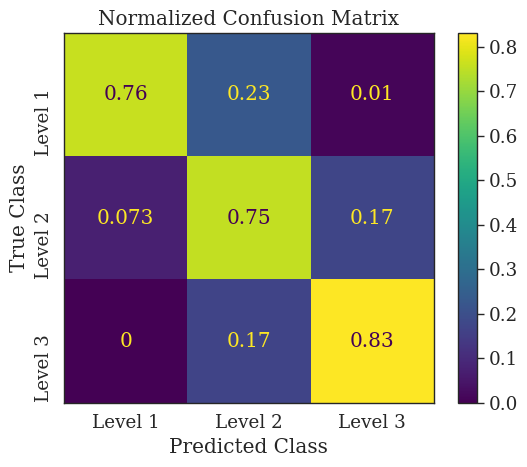

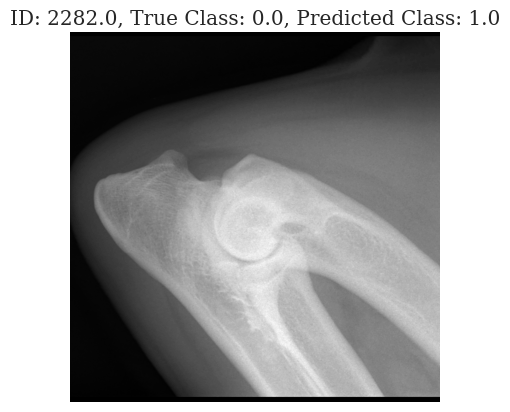

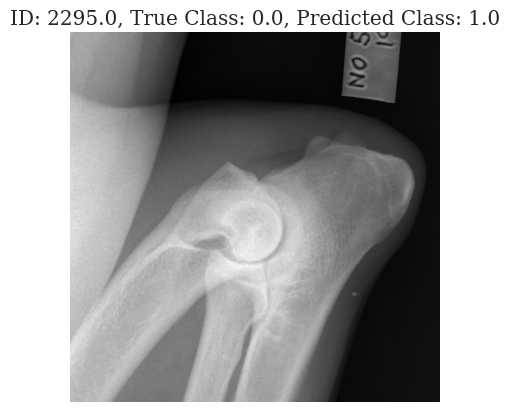

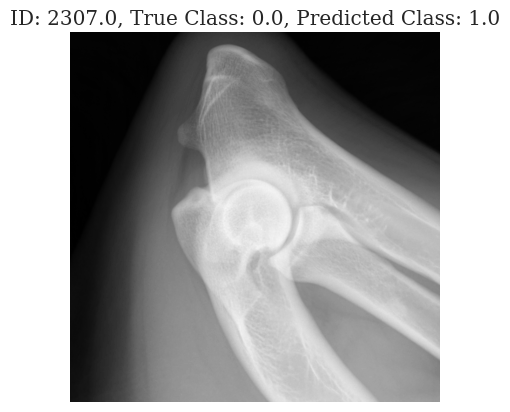

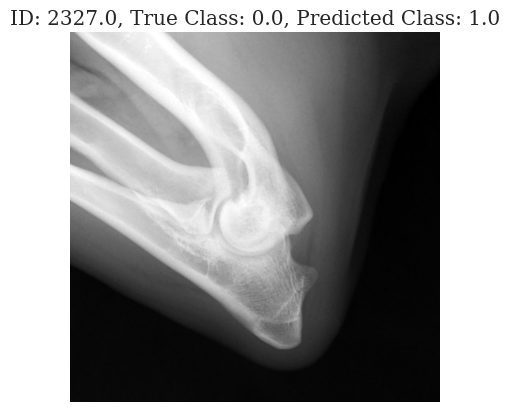

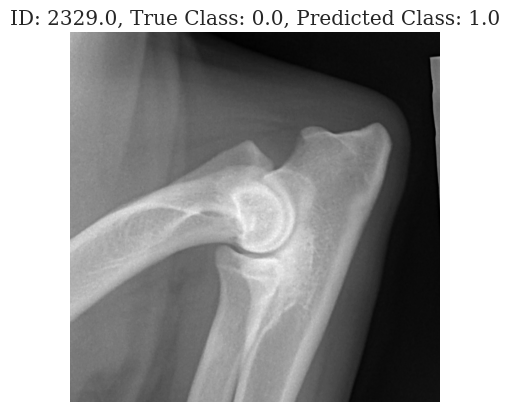

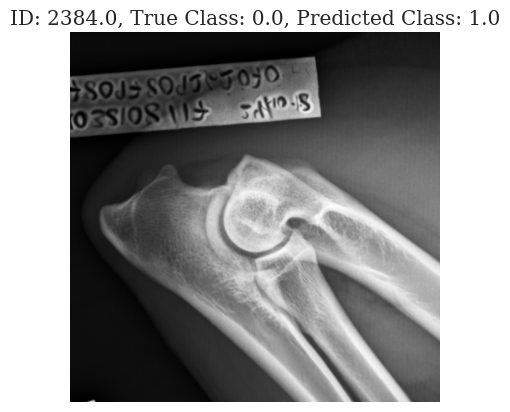

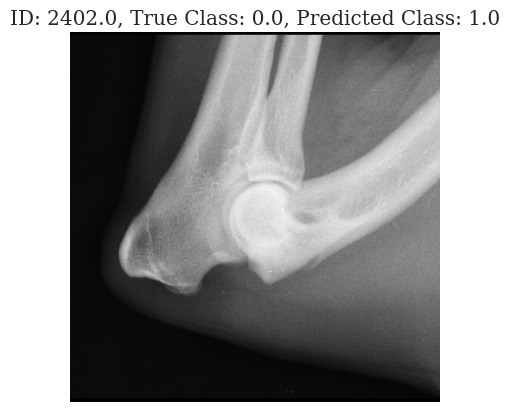

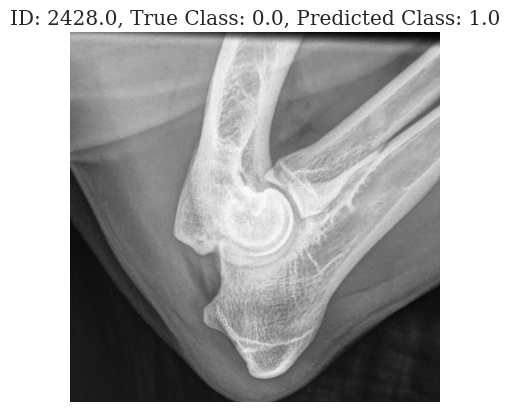

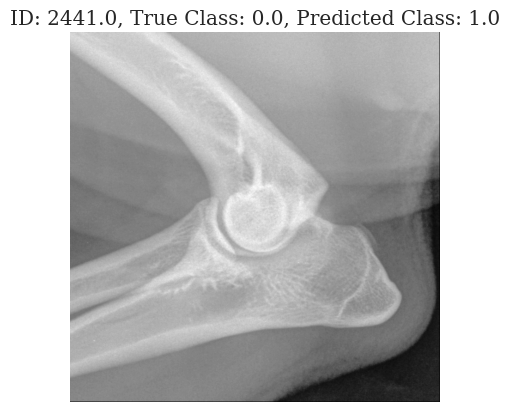

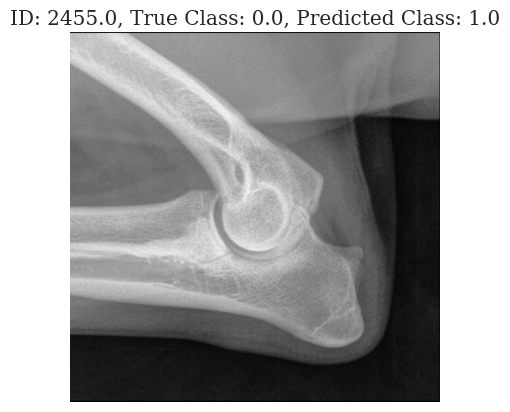

In [22]:
l=check_wrong(df,show_images=True, original_dataset=ds, images=images)